<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [76]:
from bs4 import BeautifulSoup
import requests

jobs = pd.read_csv("data/job_listings.csv")
jobs = jobs.drop(jobs.columns[0], axis=1)
print(jobs.shape)
jobs.head()

(426, 2)


,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [118]:
def extract_text(html):
    """
    Traverses the DOM; extracts text for each element and its descendants.
    """
    soup = BeautifulSoup(html, "html.parser")
    return " ".join(desc.string for desc in soup.descendants if isinstance(desc, str))


SEQ_TO_REMOVE = ["b\"", "b'", "\\\\n", "\\\\x[0-9a-fA-F]{2}", 
                 "\\\\", "'", "\d", "\+", "\*", "\W-\W"]

def clean_text(text):
    """
    Removes unnecessary sequences from the description.
    """
    for seq in SEQ_TO_REMOVE:
        text = re.sub(seq, '', text)
    return text.strip()


def scrape(html):
    """
    Scrape HTML content for descriptive text.
    """
    return clean_text(extract_text(html))


jobs["description_text"] = jobs["description"].apply(scrape)
jobs.head(5)

,description,title,description_text,spaCy_tokens
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,Job Requirements: Conceptual understanding in ...,"[job, requirements:, conceptual, understanding..."
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"Job Description As a Data Scientist , you wi...","[job, description, data, scientist, help, buil..."
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,As a Data Scientist you will be working on con...,"[data, scientist, working, consulting, busines..."
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"$,$, a month Contract Under the general superv...","[$,, $,, month, contract, general, supervision..."
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,Location: USA multiple locations years of A...,"[location:, usa, multiple, locations, years, a..."


## 2) Use Spacy to tokenize the listings 

In [119]:
from spacy.tokenizer import Tokenizer

# Initialize spaCy model and tokenizer
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

STOP_WORDS = nlp.Defaults.stop_words

def valid_token(token):
    return (token.text.lower() not in STOP_WORDS) & \
           (token.is_punct == False) & \
           (not token.text.isspace())

# Make tokens from reviews using the Tokenizer Pipe
tokens = []
for doc in tokenizer.pipe(jobs['description_text'], batch_size=500):
    doc_tokens = [token.text.lower() for token in doc if valid_token(token)]
    tokens.append(doc_tokens)

jobs['spaCy_tokens'] = tokens
jobs.head()

,description,title,description_text,spaCy_tokens
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,Job Requirements: Conceptual understanding in ...,"[job, requirements:, conceptual, understanding..."
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"Job Description As a Data Scientist , you wi...","[job, description, data, scientist, help, buil..."
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,As a Data Scientist you will be working on con...,"[data, scientist, working, consulting, busines..."
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"$,$, a month Contract Under the general superv...","[$,$,, month, contract, general, supervision, ..."
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,Location: USA multiple locations years of A...,"[location:, usa, multiple, locations, years, a..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [120]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english', max_features=1000)

corpus = jobs["description_text"]

#Learn our Vocab
vect.fit(corpus)

# Get sparse dtm
dtm = vect.transform(corpus)

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm

,abilities,ability,able,academic,access,accommodation,accommodations,accuracy,achieve,acquisition,...,worldwide,write,writing,written,www,year,years,york,youll,youre
0,0,2,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,2,1,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,3,1,1,0
422,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,2,0
423,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,2,0,0,0,0
424,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## 4) Visualize the most common word counts

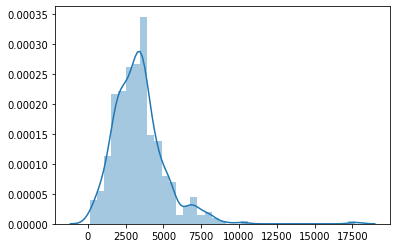

In [121]:
import seaborn as sns

doc_len = [len(doc) for doc in data]

sns.distplot(doc_len);

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [122]:
# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(corpus)

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View feature matrix as DataFrame
dtm.head()

,aa,ab,abernathy,abilities,ability,able,absence,absolutely,abstract,abundant,...,yrs,zenreach,zero,zeus,zf,zfs,zillow,zogsports,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.104878,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.022132,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.070878,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [123]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

job_description = ["Provides an exciting work environment with supportive team members"]

new = tfidf.transform(job_description)
nn.kneighbors(new.todense())

(array([[1.3356098 , 1.34235127, 1.3455974 , 1.3455974 , 1.34704336]]),
 array([[130, 324,  27,  66, 417]], dtype=int64))

In [124]:
corpus[140]

'Only local candidates will be consider for this role Who we are! Hi, we are Chewse! Hundreds of offices work with us to run their employee meal programs and culture services. On a monthly basis, we serve over , people. Chewse delivers family-style office meals from the best local restaurants. We take on the burden of planning group meals, so companies large and small can focus on doing great work, with amazing people, on time. We outperform our competition around three core value propositions. ) Curated Menus, ) Local Restaurants, and ) Consistent experience. We are a unique little team that is constantly experimenting with the best ways to have a fun, fulfilling, and productive culture. If you want to be part of a team that is paving the way for the Culture as a Service (CaaS) industry, and working on big hairy problems in order to help facilitate authentic human connection, then please reach out to us. The work is not easy, but the positive impact is real. Every day we are working h

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 